<a href="https://colab.research.google.com/github/elangalmajid/Neural-Network-SMS-Text-Classifier/blob/main/fcc_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# import libraries
!pip install tensorflow==2.8.0
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence


print(tf.__version__)

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

train_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
train_df.dropna()
train_df.head()


--2024-03-27 07:53:26--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv.1’

train-data.tsv.1    100%[===================>] 349.84K  --.-KB/s    in 0.05s   

2024-03-27 07:53:26 (7.35 MB/s) - ‘train-data.tsv.1’ saved [358233/358233]

--2024-03-27 07:53:26--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv.1’

valid-data.tsv.1    100%[========

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [ ]:
test_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
test_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [ ]:
train_df["type"] = pd.factorize(train_df["type"])[0]
test_df["type"] = pd.factorize(test_df["type"])[0]
train_df.head()

,type,msg
0,0,i am in hospital da. . i will return home in e...
1,0,"not much, just some textin'. how bout you?"
2,0,i probably won't eat at all today. i think i'm...
3,0,don‘t give a flying monkeys wot they think and...
4,0,who are you seeing?


In [ ]:
train_labels =  train_df["type"].values
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["msg"].values, train_labels)
)
test_labels =  test_df["type"].values
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["msg"].values, test_labels)
)
test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
vec = TextVectorization(
    output_mode='int',
    max_tokens=1000,
    output_sequence_length=1000,
)

vec.adapt(train_ds.map(lambda text, label: text))

In [ ]:
vocab = np.array(vec.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'you', 'a', 'the', 'u', 'and', 'is', 'in',
       'me', 'my', 'your', 'for', 'have', 'it', 'of', 'call', 'that'],
      dtype='<U16')

In [ ]:
model = tf.keras.Sequential([
    vec,
    tf.keras.layers.Embedding(
        len(vec.get_vocabulary()),
        64,
        mask_zero=True,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    validation_steps=30,
    epochs=10,
)

Epoch 1/10
44/44 [==============================] - 191s 4s/step - loss: 0.6775 - accuracy: 0.8657 - val_loss: 0.6551 - val_accuracy: 0.8604
Epoch 2/10
44/44 [==============================] - 154s 4s/step - loss: 0.6125 - accuracy: 0.8657 - val_loss: 0.5546 - val_accuracy: 0.8604
Epoch 3/10
44/44 [==============================] - 155s 4s/step - loss: 0.5075 - accuracy: 0.8657 - val_loss: 0.4690 - val_accuracy: 0.8604
Epoch 4/10
44/44 [==============================] - 156s 4s/step - loss: 0.4239 - accuracy: 0.8657 - val_loss: 0.3809 - val_accuracy: 0.8604
Epoch 5/10
44/44 [==============================] - 155s 4s/step - loss: 0.3278 - accuracy: 0.8657 - val_loss: 0.2525 - val_accuracy: 0.8604
Epoch 6/10
44/44 [==============================] - 156s 4s/step - loss: 0.1953 - accuracy: 0.8750 - val_loss: 0.1437 - val_accuracy: 0.9333
Epoch 7/10
44/44 [==============================] - 155s 4s/step - loss: 0.1175 - accuracy: 0.9634 - val_loss: 0.0908 - val_accuracy: 0.9802
Epoch 8/10
44

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

44/44 [==============================] - 28s 637ms/step - loss: 0.0447 - accuracy: 0.9878
Test Loss: 0.04465125501155853
Test Accuracy: 0.9877873659133911


(0.0, 0.7089542796835303)

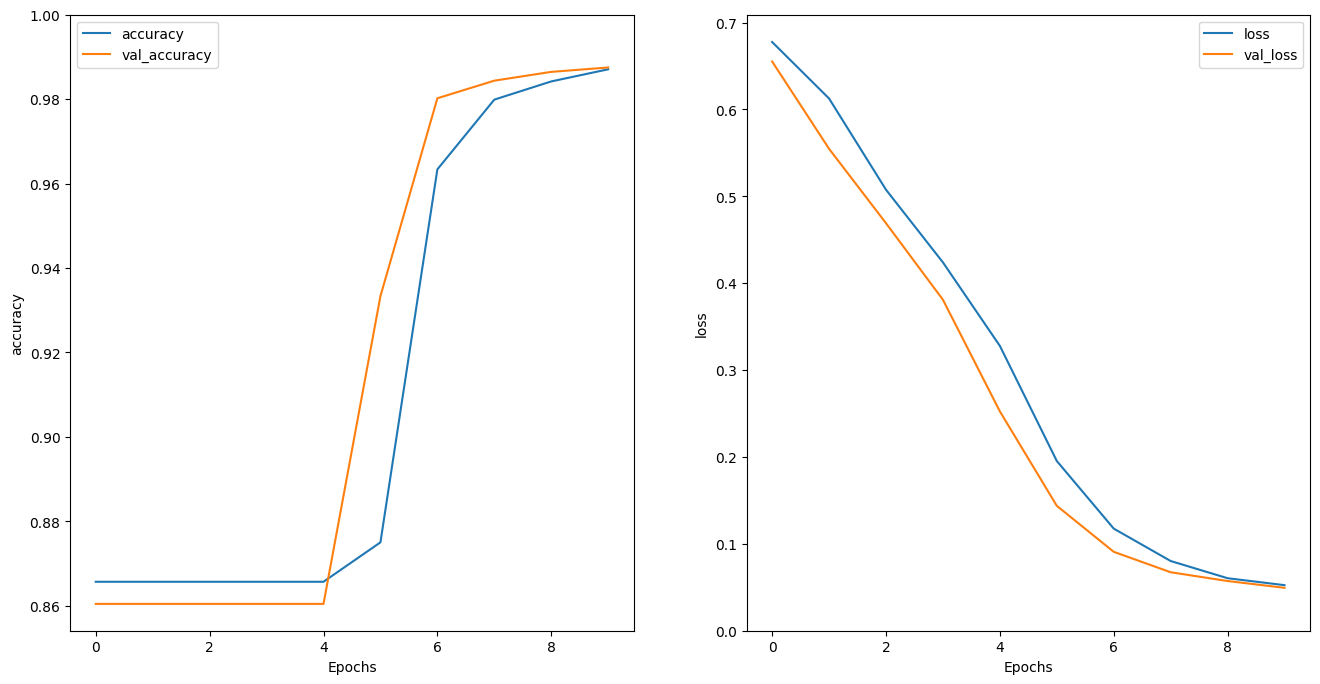

In [ ]:
def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
h = history.history
print(h['loss'])
print(h['val_loss'])
print(h['accuracy'])
print(h['val_accuracy'])

[0.6775451898574829, 0.6125221252441406, 0.5075473785400391, 0.42391327023506165, 0.32781702280044556, 0.1953393965959549, 0.11752387136220932, 0.08022299408912659, 0.06042744591832161, 0.052436456084251404]
[0.6551214456558228, 0.5546442866325378, 0.4689961075782776, 0.3809024393558502, 0.2524586319923401, 0.1437409371137619, 0.09081866592168808, 0.0672939196228981, 0.05719972029328346, 0.0493633933365345]
[0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.875, 0.9633620977401733, 0.9798850417137146, 0.9841954112052917, 0.9870689511299133]
[0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.9333333373069763, 0.9802083373069763, 0.984375, 0.9864583611488342, 0.987500011920929]


In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    ps = model.predict([pred_text])
    print(ps)
    p = ps[0][0]
    return [p, "ham" if p <0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

[[-4.616724]]
[-4.616724, 'ham']


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


[[-4.616724]]
[[0.7273215]]
[[-9.8379965]]
[[0.92073077]]
[[2.176173]]
[[-7.8494186]]
[[-9.085874]]
You passed the challenge. Great job!
